In [1]:
from plato.environment import Environment

In [2]:
config = {
  "whites":{
    "params":{
    "n_white_infantry":0,
    "n_white_vehicle":0,
    "n_white_drone":1},
    "init":"random"
  },

  "blacks":{
    "params":{
    "n_black_infantry":3,
    "n_black_vehicle":0,
    "n_black_drone":0},
    "init":"random"
  }
}

In [3]:
sim = Environment(config, shape=(32,32), time_limit=5)

In [4]:
obs = sim.reset()

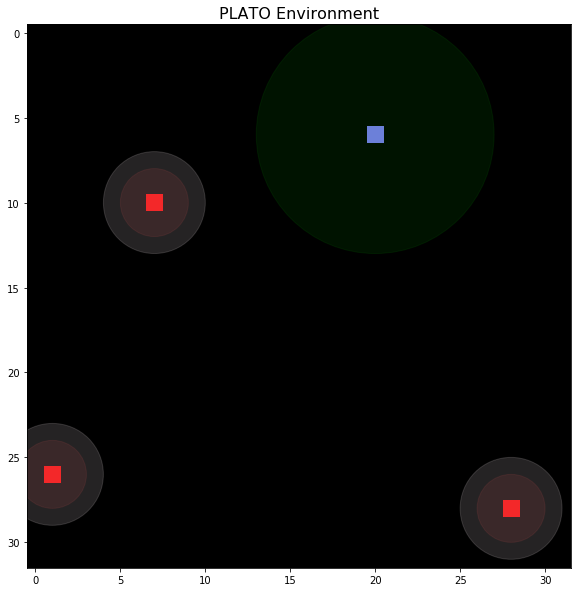

In [5]:
canvas = sim.render()

In [6]:
from plato.objective.spatiotemporal.surveil_objective import SurveilObjective
sim.objectives = [SurveilObjective(targets=sim.blacks.values())]

In [7]:
minimap = sim.observation(sim.whites, negative=None)
minimap.shape

(25, 32, 32)

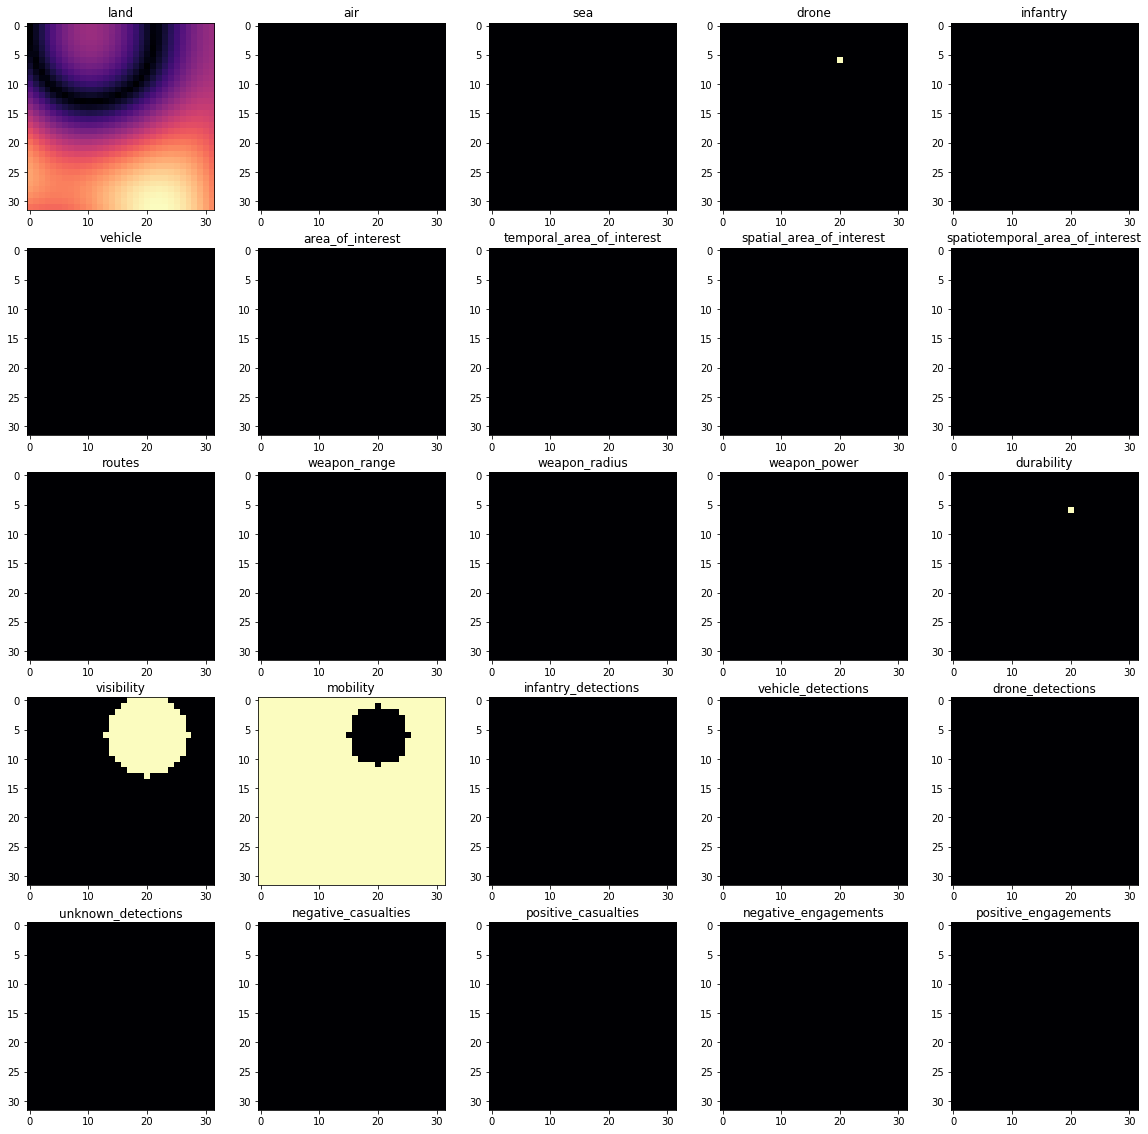

In [8]:
import numpy as np, matplotlib.pyplot as mp
from plato.features import global_features
def plot(minimap):
    fig,ax = mp.subplots(5,5, figsize=(20,20))
    for itr,(name,feat) in enumerate(zip(global_features, minimap)):
        i,j = np.unravel_index(itr,(5,5))
        ax[i,j].set_title(name)
        ax[i,j].imshow(feat, cmap='magma')
    mp.show()
plot(sim.observation(sim.whites, negative=None))

In [9]:
import collections
class Memory(object):
    def __init__(self, capacity=2**20):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, sprime, terminal):
        state  = np.asarray(state).astype(np.float32)
        action = np.asarray(action).astype(np.float32)
        reward = np.asarray(reward).astype(np.float32)
        sprime = np.asarray(sprime).astype(np.float32)
        terminal = np.asarray(terminal).astype(np.float32)
        self.buffer.append((state, action, reward, sprime, terminal))

    def save(self, saver):
        np.save(saver, np.asarray(self.buffer))

    def sample(self, bsize=1):
        s,a,r,s_,t = zip(*random.sample(self.buffer, bsize))
        return np.array(s), np.array(a), np.array(r), np.array(s_), np.array(t)

    def __len__(self):
        return len(self.buffer)

In [10]:
class Controller(object):
    def __init__(self):
        super().__init__()
        self.shared_drone_experience = Memory()
        
        self.filter_entities= lambda entities:{id:ent for id,ent in entities.items() if ent.entity_type == 'drone' and ent.operational}
        self.filter_actions = lambda entities:{id:ent.random_action() for id,ent in entities.items()}
    
    def localize_observation(self, entity):
        identity = np.zeros((*minimap.shape[1:],))
        identity[entity.xy[0],entity.xy[1]] = 1
        identity = np.expand_dims(identity,axis=0)
        return np.concatenate([identity, minimap],axis=0)
            
    def retain(self,s,entities,a,r,s_,entities_,t):
        entities = self.filter_entities(entities)
        entities_= self.filter_entities(entities_)
        for (entity,action,entity_) in zip(entities.values(),a.values(),entities_.values()):
            s = self.localize_observation(entity)
            s_= self.localize_observation(entity_)
            self.shared_drone_experience.push(s,action,r,s_,t)

controller = Controller()

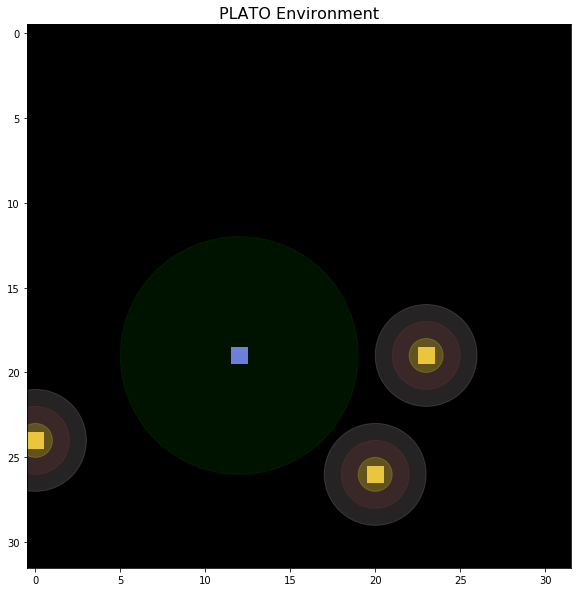

Reward: 0


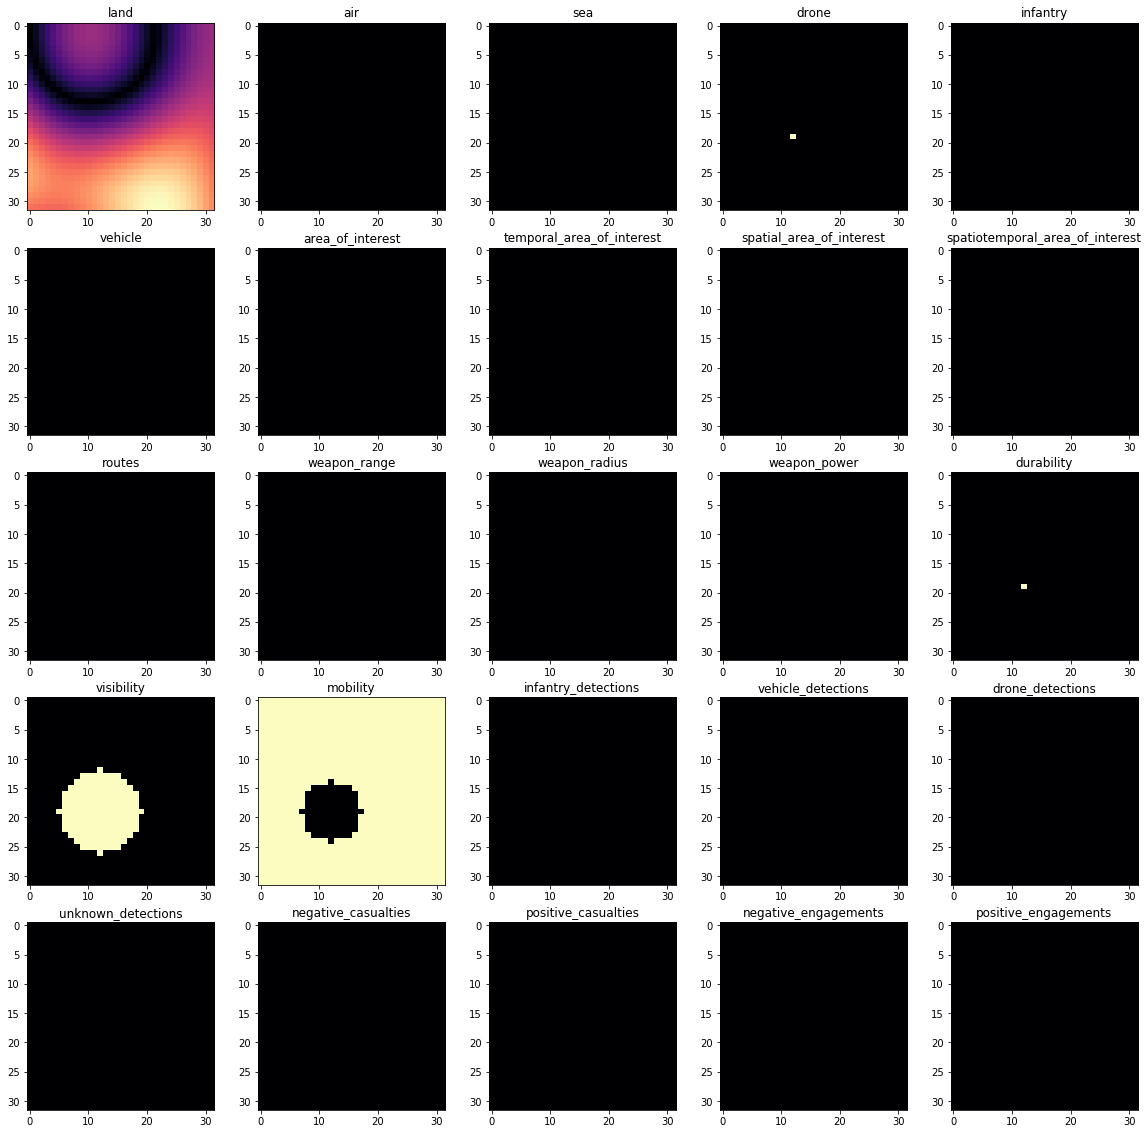

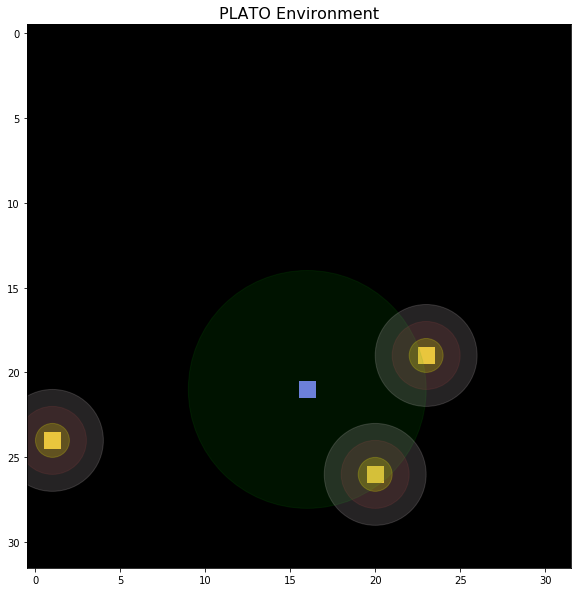

Reward: 0


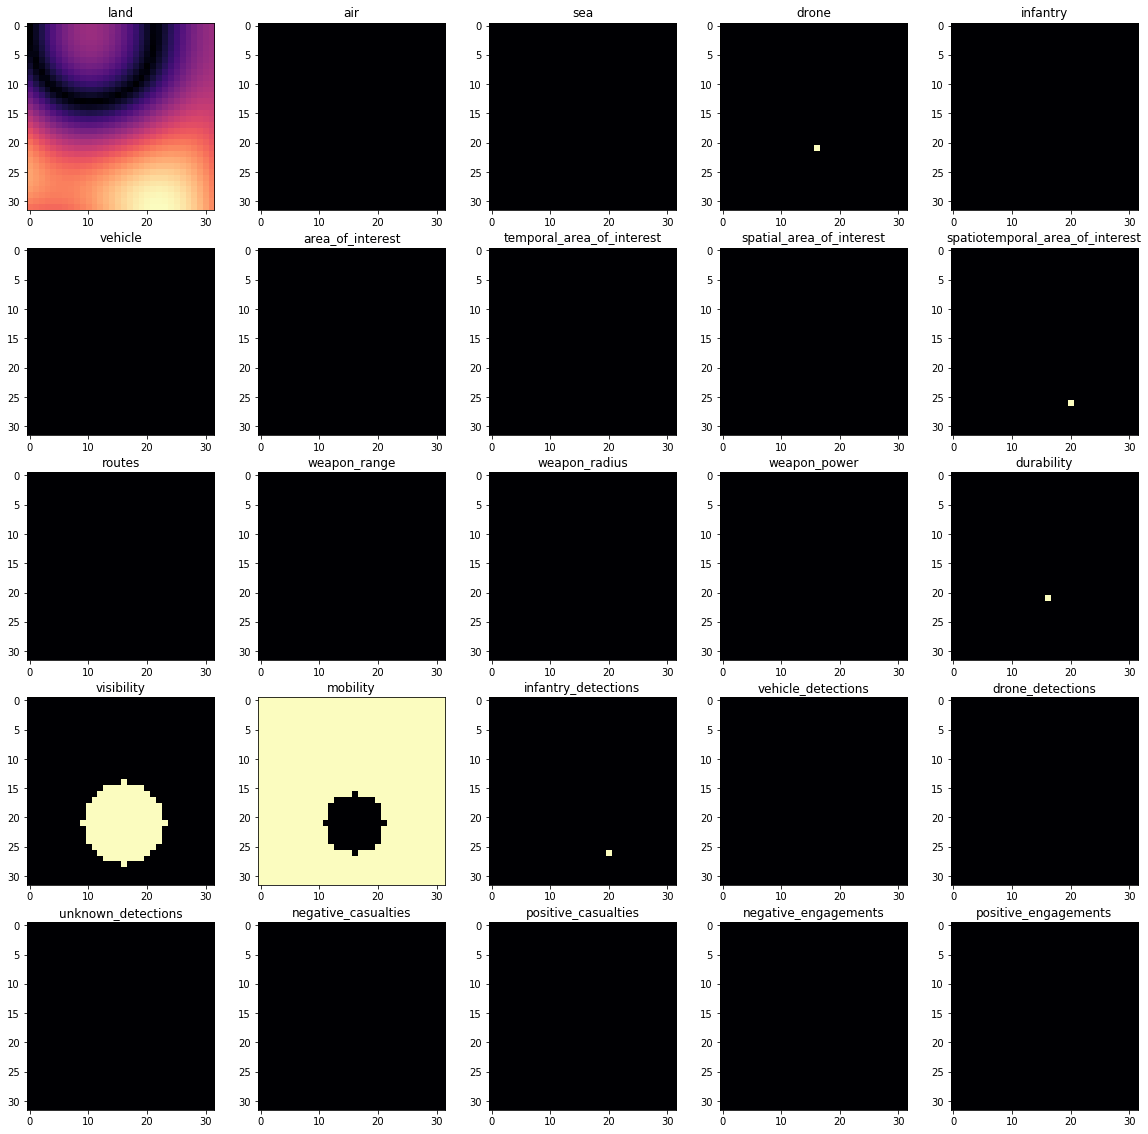

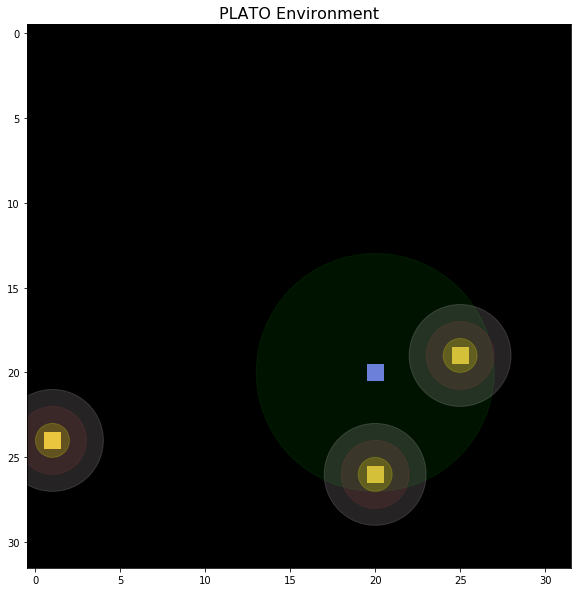

Reward: 1


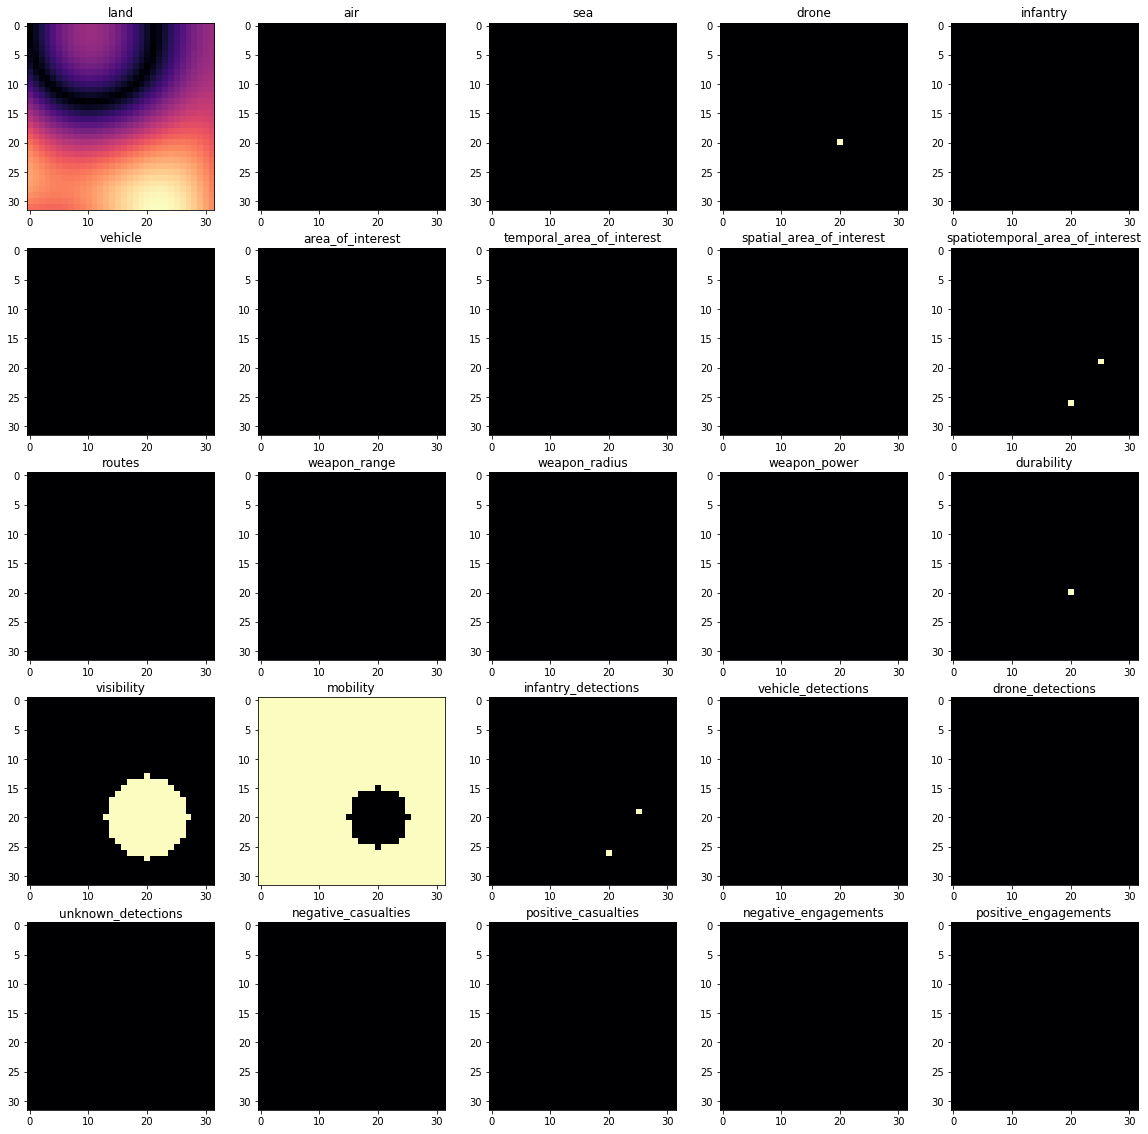

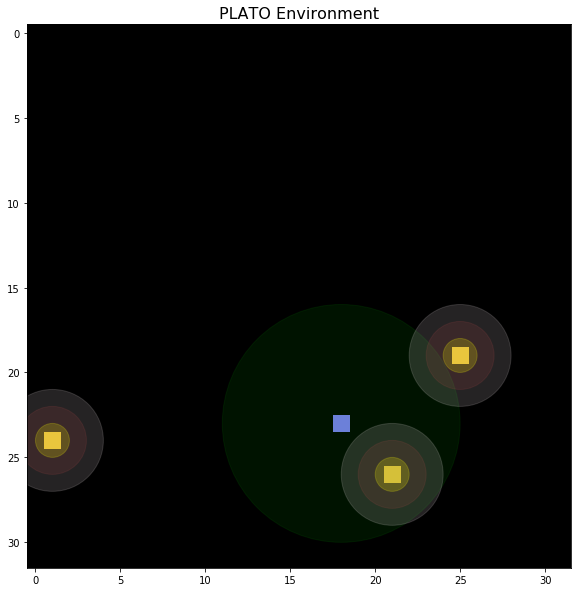

Reward: 2


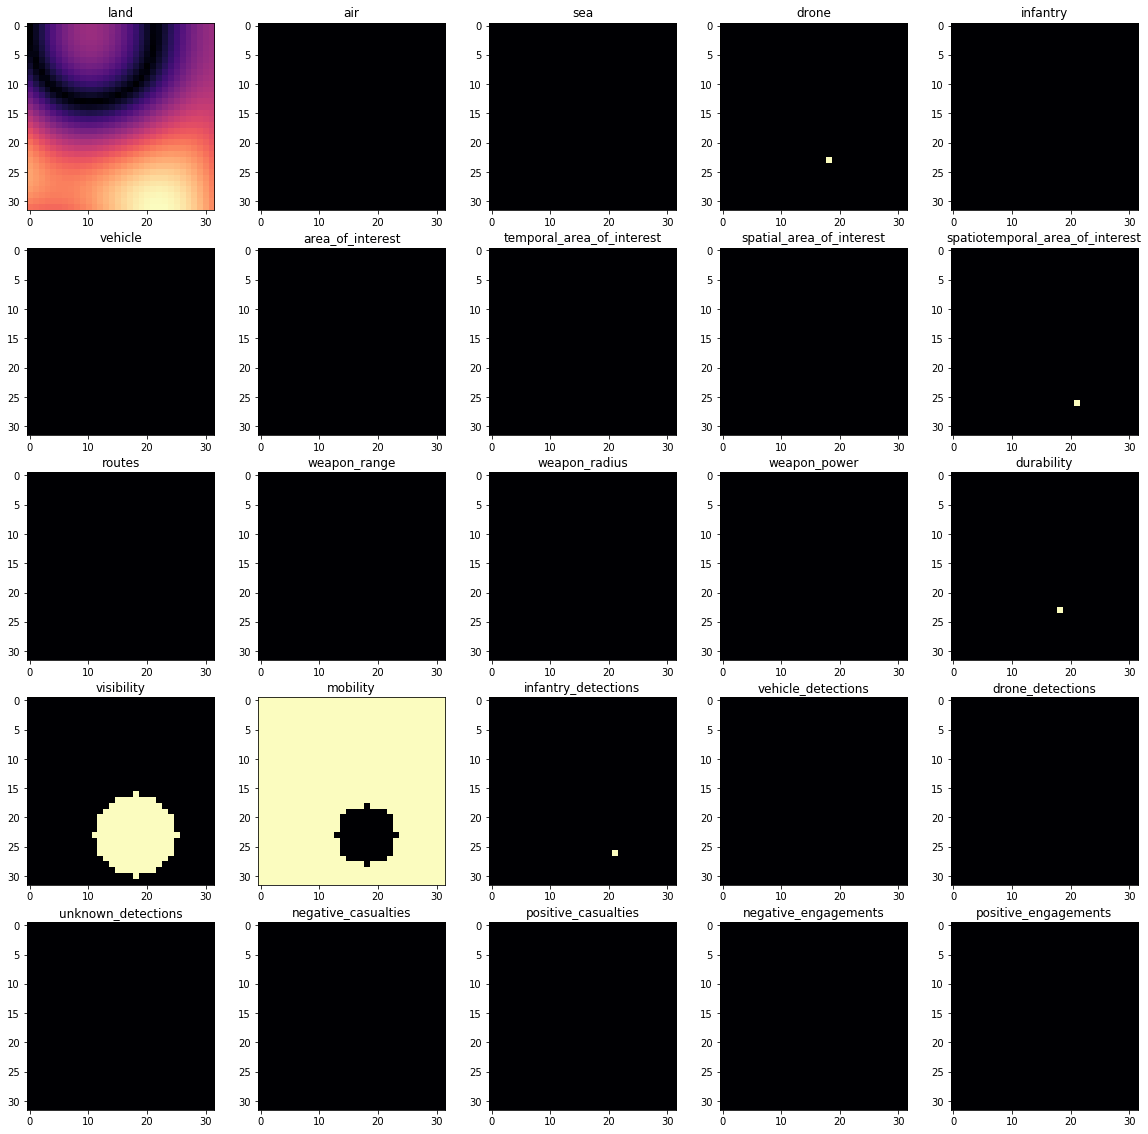

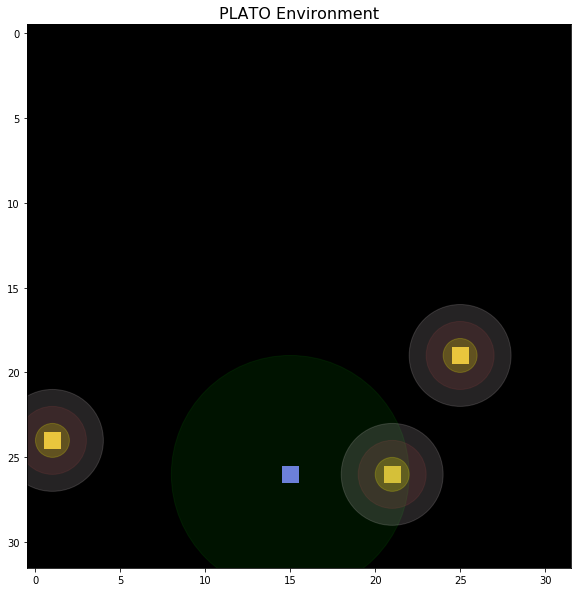

Reward: 1


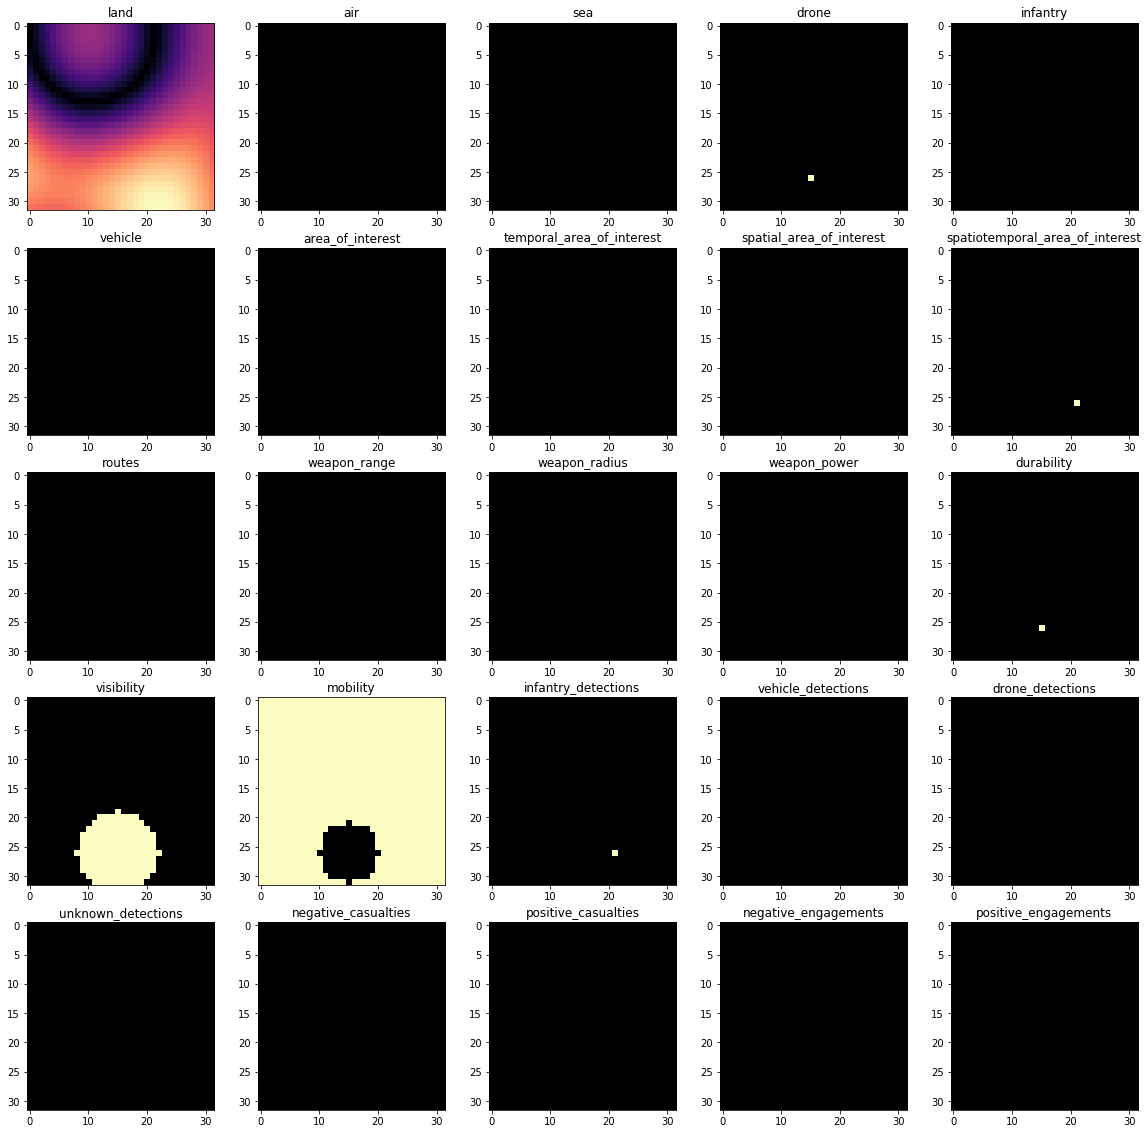

In [11]:
import copy, random, tqdm
sim.reset()
bar = tqdm.tqdm_notebook(total=sim.time_limit)

terminal = False
while not terminal:
    entities,enemies = copy.deepcopy(sim.whites), sim.blacks
    actions = {id:ent.random_action() for id,ent in entities.items() if ent.operational}
    enemies = {id:ent.random_action() for id,ent in enemies.items() if ent.operational}

    state = sim.observation(sim.whites)
    sprime, reward, terminal, metadata = sim.step(actions, enemies)
    
    controller.retain(state, entities, actions, reward, sprime, sim.whites, terminal)

    sim.render()
    print('Reward:',reward)
    plot(sim.observation(sim.whites, negative=None))
    
    state = sprime
    bar.update(1)